In [2]:
from __future__ import unicode_literals
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import data_utils as dutils
from pathlib import Path
from datetime import datetime, timedelta
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

plt.style.use("fivethirtyeight")

%matplotlib inline
import warnings
warnings.filterwarnings(action='once')

In [3]:
data = dutils.loadData()

In [4]:
data.head()

,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,TOTNEG,QUATOT,VOLTOT
DATPRG,,,,,,,,,,
2020-01-02,112.45,114.24,112.13,113.41,114.24,114.24,114.27,44941,5684380,644704844.5
2020-01-03,112.93,114.50,112.80,113.67,113.80,113.79,113.80,41215,6602450,750525102.8
2020-01-06,113.00,113.45,112.02,112.69,112.59,112.50,112.59,49161,6771940,763170182.1
2020-01-07,112.90,112.90,111.59,112.15,112.24,112.24,112.50,82364,6096900,683798812.7
2020-01-08,112.65,113.10,111.40,112.09,111.95,111.90,111.95,46982,6472610,725559204.5


In [5]:
data.drop(columns=list(data.columns[data.nunique() <= 1]), inplace=True)
data.head()

,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,TOTNEG,QUATOT,VOLTOT
DATPRG,,,,,,,,,,
2020-01-02,112.45,114.24,112.13,113.41,114.24,114.24,114.27,44941,5684380,644704844.5
2020-01-03,112.93,114.50,112.80,113.67,113.80,113.79,113.80,41215,6602450,750525102.8
2020-01-06,113.00,113.45,112.02,112.69,112.59,112.50,112.59,49161,6771940,763170182.1
2020-01-07,112.90,112.90,111.59,112.15,112.24,112.24,112.50,82364,6096900,683798812.7
2020-01-08,112.65,113.10,111.40,112.09,111.95,111.90,111.95,46982,6472610,725559204.5


In [6]:
data.describe().to_clipboard()

In [9]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def get_score(m, X_val, y_val):
    res = [rmse(m.predict(X_val), y_val), m.score(X_val, y_val)]
    print(f"RMSE: {res[0]} | R2: {res[1]}")
    return res

In [5]:
X_train, y_train, X_val, y_val = getTrainTestDataWithEmotion(perc=percent, normalize=normalize)

NameError: name 'getTrainTestDataWithEmotion' is not defined

In [10]:
def plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, title='Close Price History', X_train = [], y_train = [],full=False):
    if full == True:
        data = X_train.append(X_val)
        target = list(y_train)
        y_val = list(y_val)
        target.extend(y_val)
    else: 
        target = y_val
        data = X_val
    pltdata = pd.DataFrame({"Target": target}, index=data.index)
    pltdata["SVR"] = SVR_m.predict(data)
    pltdata["Bayes"] = bayes_m.predict(data)
    pltdata["LR"] = LR_m.predict(data)
    pltdata["RF"] = RF_m.predict(data)
    ax = pltdata.plot(style='.-', figsize=(16,8), title=title)
    ax.set_xlabel("Data")
    ax.set_ylabel("Preço (R$)")

In [11]:
def getTrainTestData(perc=0.75, normalize=False):
    df = dutils.loadData()
    return dutils.getTrainTestSets(df, perc=perc, normalize=normalize)

In [12]:
def trainSVR(X_train, y_train, parameters=None):
    if parameters == None:
        parameters = {
            "kernel": ["rbf", "sigmoid"],
            "C": [1,10,10,100,1000],
            "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
        }
        cv = ShuffleSplit(test_size=0.01, n_splits=1)
        grid = GridSearchCV(SVR(), parameters, cv=cv, verbose=0, return_train_score=True)
        grid.fit(X_train, y_train)
        return grid.best_estimator_
    new_model = SVR(kernel=parameters["kernel"], C=parameters["C"], gamma=parameters["gamma"], epsilon=parameters["epsilon"])
    new_model.fit(X_train, y_train)
    return new_model

In [13]:
def trainRF(X_train, y_train, parameters=None):
    estimators = range(1, 20)
    leaves = range(1,40)
    if parameters == None:
        parameters = {
            "n_estimators": estimators,
            "min_samples_leaf": leaves,
        }
        cv = ShuffleSplit(test_size=0.01, n_splits=1)
        grid = GridSearchCV(RandomForestRegressor(bootstrap=True), parameters, cv=cv, verbose=0, return_train_score=True)
        grid.fit(X_train, y_train)
        return grid.best_estimator_
    new_model = RandomForestRegressor(bootstrap=True, n_estimators=parameters["n_estimators"], min_samples_leaf=parameters["min_samples_leaf"])
    new_model.fit(X_train, y_train)
    return new_model

In [14]:
def trainBayes(X_train, y_train, parameters=None):
    clf = BayesianRidge(compute_score=True)
    if parameters == None:
        parameters = {
            "n_iter": [15, 60, 150, 250, 300],
            "alpha_1": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
            "alpha_2": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
            "lambda_1": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
            "lambda_2": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],    
        }
        cv = ShuffleSplit(test_size=0.01, n_splits=1)
        grid = GridSearchCV(BayesianRidge(compute_score=True, copy_X=True), parameters, cv=cv, verbose=0, return_train_score=True)
        grid.fit(X_train, y_train)
        return grid.best_estimator_
    new_model = BayesianRidge(compute_score=True, copy_X=True, n_iter=parameters["n_iter"], alpha_1=parameters["alpha_1"], alpha_2=parameters["alpha_2"], lambda_1=parameters["lambda_1"], lambda_2=parameters["lambda_2"])
    new_model.fit(X_train, y_train)
    return new_model

In [15]:
def trainLR(X_train, y_train):
    reg = LinearRegression(copy_X=True)
    reg.fit(X_train, y_train)
    return reg

In [16]:
def getResults(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val):
    results = {}
    print(f"SVR Score: ")
    results["SVR"] = get_score(SVR_m, X_val, y_val)
    print(f"\nRF Score: ")
    results["RF"] = get_score(RF_m, X_val, y_val)
    print(f"\nBayes Score: ")
    results["Bayes"] = get_score(bayes_m, X_val, y_val)
    print(f"\nLR Score: ")
    results["LR"] = get_score(LR_m, X_val, y_val)    
    return results

In [17]:
def getTrainedModels(X_train, y_train):
    SVR_m = trainSVR(X_train, y_train)
    RF_m = trainRF(X_train, y_train)
    bayes_m = trainBayes(X_train, y_train)
    LR_m = trainLR(X_train, y_train)
    return SVR_m, RF_m, bayes_m, LR_m

In [18]:
def trainModel(percent, normalize=False):
    print(f"\n Training with split: {percent * 100}% \n")
    X_train, y_train, X_val, y_val = getTrainTestData(perc=percent, normalize=normalize)
    SVR_m, RF_m, bayes_m, LR_m = getTrainedModels(X_train, y_train)
    plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val)
    results = {}
    print(f"SVR Score: ")
    results["SVR"] = get_score(SVR_m, X_val, y_val)
    print(f"\nRF Score: ")
    results["RF"] = get_score(RF_m, X_val, y_val)
    print(f"\nBayes Score: ")
    results["Bayes"] = get_score(bayes_m, X_val, y_val)
    print(f"\nLR Score: ")
    results["LR"] = get_score(LR_m, X_val, y_val) 
    return results

In [19]:
import json
def saveResults(results, name):
    with open(f'{name}.json', 'w') as fp:
        json.dump(results, fp)

In [20]:
def getTrainTestData_TA(perc=0.75, normalize=False):
    df = dutils.loadData()
    emo_df = dutils.loadEmoData()
    emo_df.fillna(0, inplace=True)
    mergedDf = df.merge(emo_df, right_index=True, left_index=True)
    return dutils.getTrainTestSets_TA(mergedDf, perc=perc, with_emotions=False, normalize=normalize)

In [21]:
def getTrainTestDataWithEmotion(perc=0.75, normalize=False):
    df = dutils.loadData()
    emo_df = dutils.loadEmoData()
    emo_df.fillna(0, inplace=True)
    mergedDf = df.merge(emo_df, right_index=True, left_index=True)
    return dutils.getTrainTestSets(mergedDf, perc=perc, with_emotions=True, normalize=normalize)

In [20]:
X_train, y_train, X_val, y_val, scaler = getTrainTestDataWithEmotion(perc=0.75, normalize=True)

In [15]:
X_train

,PREABE,PREMAX,PREMIN,PREMED,PREOFC,PREOFV,PREULT,TOTNEG,QUATOT,VOLTOT,SUR,ANG,JOY,FEA,TRU,ANT,SAD,DIS
2020-05-04,0.029008,0.005435,0.057727,0.025187,0.048367,0.041719,0.048306,0.793903,0.309003,0.191814,0.001368,0.0,0.015048,0.060192,0.009576,0.000000,0.025992,0.067031
2020-05-05,0.086089,0.064258,0.100722,0.081157,0.062186,0.059735,0.062108,0.027432,0.380652,0.262773,0.000000,0.0,0.010558,0.055807,0.007541,0.001508,0.036199,0.075415
2020-05-06,0.080474,0.029731,0.069152,0.043843,0.050879,0.044248,0.051443,0.065074,0.065922,0.000000,0.000000,0.0,0.033183,0.058824,0.006033,0.004525,0.036199,0.093514
2020-05-07,0.088584,0.034527,0.069753,0.044465,0.026382,0.027497,0.026349,0.122809,0.455621,0.314305,0.000000,0.0,0.018156,0.046089,0.009777,0.000000,0.037709,0.078212
2020-05-08,0.084217,0.046355,0.109741,0.073694,0.089196,0.083123,0.090025,0.476024,0.359942,0.244080,0.001650,0.0,0.021452,0.051155,0.008251,0.001650,0.046205,0.107261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,0.533375,0.506394,0.517739,0.512438,0.544598,0.540771,0.544228,0.116552,0.487195,0.470943,0.000000,0.0,0.025974,0.053129,0.005903,0.000000,0.024793,0.069658
2020-10-02,0.531192,0.522698,0.518942,0.514303,0.488379,0.486726,0.487767,0.693887,0.348395,0.337333,0.000000,0.0,0.019391,0.044321,0.002770,0.000000,0.031856,0.096953
2020-10-05,0.518403,0.534847,0.529164,0.535448,0.566583,0.563843,0.567127,0.537500,0.187028,0.185143,0.001515,0.0,0.022727,0.050000,0.006061,0.001515,0.027273,0.100000
2020-10-06,0.592327,0.566176,0.564041,0.564366,0.547739,0.544564,0.547992,0.479057,0.405569,0.405191,0.000000,0.0,0.009950,0.053483,0.004975,0.000000,0.034826,0.105721


In [374]:
def trainEmoModel(percent, normalize=False):
    print(f"\n Training with split: {percent * 100}% \n")
    X_train, y_train, X_val, y_val = getTrainTestDataWithEmotion(perc=percent, normalize=normalize)
    SVR_m, RF_m, bayes_m, LR_m = getTrainedModels(X_train, y_train)
    plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val)
    results = {}
    print(f"SVR Score: ")
    results["SVR"] = get_score(SVR_m, X_val, y_val)
    print(f"\nRF Score: ")
    results["RF"] = get_score(RF_m, X_val, y_val)
    print(f"\nBayes Score: ")
    results["Bayes"] = get_score(bayes_m, X_val, y_val)
    print(f"\nLR Score: ")
    results["LR"] = get_score(LR_m, X_val, y_val)  
    return results

In [536]:
FEATURES = ['PREABE','PREMAX','PREMIN','PREMED','PREOFC','PREOFV', 'PREULT']
df = dutils.loadData()[FEATURES]
df.describe()

,PREABE,PREMAX,PREMIN,PREMED,PREOFC,PREOFV,PREULT
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,93.874138,94.913534,92.656767,93.771509,93.739828,93.806810,93.769397
std,12.618101,12.328683,13.005627,12.666318,12.699059,12.686205,12.703585
min,62.900000,66.300000,59.100000,61.530000,61.130000,61.140000,61.140000
25%,87.092500,88.695000,85.475000,86.932500,88.402500,88.422500,88.417500
50%,95.475000,96.810000,95.005000,95.920000,95.765000,95.795000,95.765000
75%,100.870000,101.782500,99.862500,100.855000,100.882500,100.917500,100.917500
max,115.210000,115.260000,113.710000,114.210000,115.210000,115.240000,115.210000


In [606]:
percs = [0.51, 0.61, 0.65, 0.71, 0.75, 0.81]
warnings.filterwarnings("ignore")
np.random.seed(100)
r = {}
for perc in percs:
    X_train, y_train, X_val, y_val, scaler = getTrainTestData(perc=perc, normalize=True)
    SVR_m = trainSVR(X_train, y_train)
    RF_m = trainRF(X_train, y_train)
    bayes_m = trainBayes(X_train, y_train)
    LR_m = trainLR(X_train, y_train)
    print(f"SVR {perc} Score: ")
    svrPerc = f"SVR_{perc}"
    r[svrPerc] = get_score_unscaled(SVR_m, X_val, y_val, scaler)
    print(f"\nRF {perc} Score: ")
    rfPerc = f"RF_{perc}"
    r[rfPerc] = get_score_unscaled(RF_m, X_val, y_val, scaler)
    print(f"\nBayes {perc} Score: ")
    bayesPerc = f"Bayes_{perc}"
    r[bayesPerc] = get_score_unscaled(bayes_m, X_val, y_val, scaler)    
    print(f"\nLR {perc} Score: ")
    lrPerc = f"LR_{perc}"
    r[lrPerc] = get_score_unscaled(LR_m, X_val, y_val, scaler)


SVR 0.51 Score: 
RMSE: 5.814247517147141 | R2: -1271524258614.2544

RF 0.51 Score: 
RMSE: 3.094988680040277 | R2: 0.1496232427280101

Bayes 0.51 Score: 
RMSE: 1.2399553039393016 | R2: 0.8866594749232031

LR 0.51 Score: 
RMSE: 8.847183976966626 | R2: -0.060700176767100045
SVR 0.61 Score: 
RMSE: 4.741573058341467 | R2: -543092475489.40234

RF 0.61 Score: 
RMSE: 2.7762185226876985 | R2: 0.3463146409934268

Bayes 0.61 Score: 
RMSE: 1.296771032148858 | R2: 0.9005468931173026

LR 0.61 Score: 
RMSE: 7.223951038776133 | R2: 0.017372521787103357
SVR 0.65 Score: 
RMSE: 4.952814867655732 | R2: -521417460523.99457

RF 0.65 Score: 
RMSE: 3.3927950129649718 | R2: -0.23145623048968145

Bayes 0.65 Score: 
RMSE: 1.3424041027202396 | R2: 0.9038315264868199

LR 0.65 Score: 
RMSE: 6.329761538027203 | R2: 0.0933546867480124
SVR 0.71 Score: 
RMSE: 1.9311167240223033 | R2: 0.7436203633667348

RF 0.71 Score: 
RMSE: 5.060470112888631 | R2: -0.06691271894979844

Bayes 0.71 Score: 
RMSE: 1.3370315862568658 | R2:

In [607]:
r

{'SVR_0.51': [5.814247517147141, -1271524258614.2544],
 'RF_0.51': [3.094988680040277, 0.1496232427280101],
 'Bayes_0.51': [1.2399553039393016, 0.8866594749232031],
 'LR_0.51': [8.847183976966626, -0.060700176767100045],
 'SVR_0.61': [4.741573058341467, -543092475489.40234],
 'RF_0.61': [2.7762185226876985, 0.3463146409934268],
 'Bayes_0.61': [1.296771032148858, 0.9005468931173026],
 'LR_0.61': [7.223951038776133, 0.017372521787103357],
 'SVR_0.65': [4.952814867655732, -521417460523.99457],
 'RF_0.65': [3.3927950129649718, -0.23145623048968145],
 'Bayes_0.65': [1.3424041027202396, 0.9038315264868199],
 'LR_0.65': [6.329761538027203, 0.0933546867480124],
 'SVR_0.71': [1.9311167240223033, 0.7436203633667348],
 'RF_0.71': [5.060470112888631, -0.06691271894979844],
 'Bayes_0.71': [1.3370315862568658, 0.9092332101541846],
 'LR_0.71': [9.468989827245395, -0.0035189192550753035],
 'SVR_0.75': [1.6280228954105445, 0.838184712811636],
 'RF_0.75': [4.8541803812277395, -2.9598519392991993],
 'Bay

# Train -  No emotion first

In [ ]:
results = {}
# No emo No Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestData(perc=0.75, normalize=False)
SVR_m = trainSVR(X_train, y_train)
RF_m = trainRF(X_train, y_train)
bayes_m = trainBayes(X_train, y_train)
LR_m = trainLR(X_train, y_train)
results_no_no = {}
print(f"SVR No Emo No Normalize Score: ")
results_no_no["SVR"] = get_score(SVR_m, X_val, y_val)
print(f"\nRF No Emo No Normalize Score: ")
results_no_no["RF"] = get_score(RF_m, X_val, y_val)
print(f"\nBayes No Emo No Normalize Score: ")
results_no_no["Bayes"] = get_score(bayes_m, X_val, y_val)
print(f"\nLR No Emo No Normalize Score: ")
results_no_no["LR"] = get_score(LR_m, X_val, y_val) 
results["NN"] = results_no_no
plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, title="Histórico de preços não-normalizados (sem valores de emoção)")

In [ ]:
# Yes emo No Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestDataWithEmotion(perc=0.75, normalize=False)
SVR_m = trainSVR(X_train, y_train, SVR_m.get_params())
RF_m = trainRF(X_train, y_train, RF_m.get_params())
bayes_m = trainBayes(X_train, y_train, bayes_m.get_params())
LR_m = trainLR(X_train, y_train)
results_yes_no = {}
print(f"SVR Yes Emo No Normalize Score: ")
results_yes_no["SVR"] = get_score(SVR_m, X_val, y_val)
print(f"\nRF Yes Emo No Normalize Score: ")
results_yes_no["RF"] = get_score(RF_m, X_val, y_val)
print(f"\nBayes Yes Emo No Normalize Score: ")
results_yes_no["Bayes"] = get_score(bayes_m, X_val, y_val)
print(f"\nLR Yes Emo No Normalize Score: ")
results_yes_no["LR"] = get_score(LR_m, X_val, y_val)
results["YN"] = results_yes_no
plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, title="Histórico de preços não-normalizados (com valores de emoção)")

In [34]:
# TA
X_train, y_train, X_val, y_val = getTrainTestData_TA(perc=0.75, normalize=False)
SVR_m = trainSVR(X_train, y_train)
RF_m = trainRF(X_train, y_train)
bayes_m = trainBayes(X_train, y_train)
LR_m = trainLR(X_train, y_train)
results_yes_no = {}
print(f"SVR Yes Emo No Normalize Score: ")
results_yes_no["SVR"] = get_score(SVR_m, X_val, y_val)
print(f"\nRF Yes Emo No Normalize Score: ")
results_yes_no["RF"] = get_score(RF_m, X_val, y_val)
print(f"\nBayes Yes Emo No Normalize Score: ")
results_yes_no["Bayes"] = get_score(bayes_m, X_val, y_val)
print(f"\nLR Yes Emo No Normalize Score: ")
results_yes_no["LR"] = get_score(LR_m, X_val, y_val)
results["YN"] = results_yes_no
plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, title="Histórico de preços não-normalizados (com valores de emoção)")

SVR Yes Emo No Normalize Score: 
RMSE: 8.463863662823718 | R2: -2.6179123717230017

RF Yes Emo No Normalize Score: 
RMSE: 3.295865815487904 | R2: 0.45139498979247095

Bayes Yes Emo No Normalize Score: 
RMSE: 1.5462453974716877 | R2: 0.8792526618875797

LR Yes Emo No Normalize Score: 
RMSE: 1.5354687087952585 | R2: 0.880929914236651


NameError: name 'results' is not defined

In [55]:
test = X_train.append(X_val)
test_y = list(y_train)
test_y.extend(y_val)
len(test), len(test_y)

(146, 146)

In [49]:
RF_m_mf = trainRF(test, test_y, RF_m.get_params())

In [51]:
import pickle

In [52]:
filename = 'RF_M.pickle'
pickle.dump(RF_m_mf, open(filename, 'wb'))

/Users/marcelcanhisares/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.BufferedWriter name='RF_M.pickle'>
  


In [56]:
test_m = pickle.load(open(filename, 'rb'))

/Users/marcelcanhisares/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='RF_M.pickle'>
  """Entry point for launching an IPython kernel.


In [57]:
test.head()

,PREABE,PREMAX,PREMIN,PREULT,TOTNEG
2020-05-04,75.17,76.30,74.77,76.10,79102
2020-05-05,77.00,78.14,76.20,76.54,3272
2020-05-06,76.82,77.06,75.15,76.20,6996
2020-05-07,77.08,77.21,75.17,75.40,12708
2020-05-08,76.94,77.58,76.50,77.43,47653


In [60]:
ent = np.array([21.42, 21.54, 21.32, 21.51, 2802700])

In [65]:
right = ent.reshape(1, -1)

In [66]:
test_m.predict(right)

array([79.47818182])

SVR No Emo Yes Normalize Score: 
RMSE: 1.6280228954105445 | R2: 0.838184712811636

RF No Emo Yes Normalize Score: 
RMSE: 3.0898678176130265 | R2: -0.17004208754884664

Bayes No Emo Yes Normalize Score: 
RMSE: 1.386377309527086 | R2: 0.8874386382638484

LR No Emo Yes Normalize Score: 
RMSE: 9.92244830152364 | R2: -0.0574545094147878


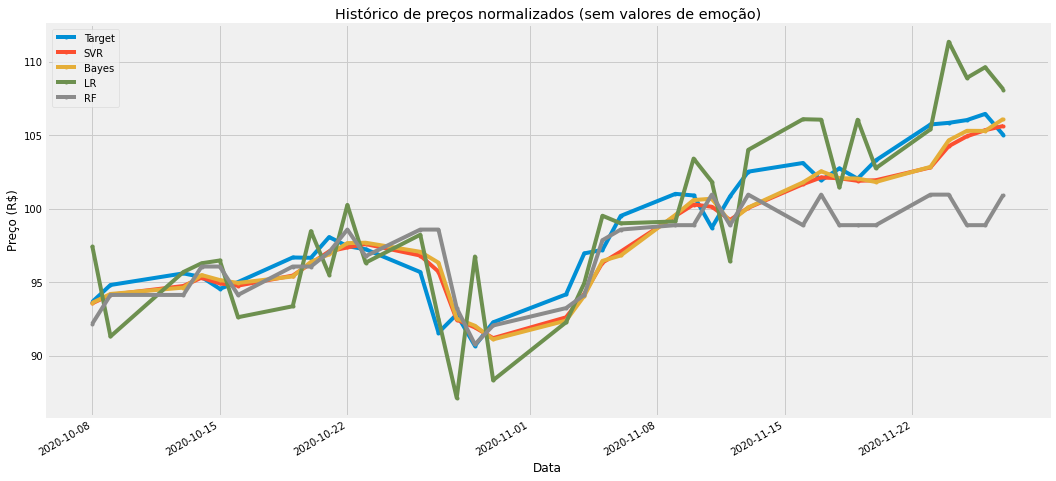

In [622]:
# No emo Yes Normalize
np.random.seed()
X_train, y_train, X_val, y_val, scaler = getTrainTestData(perc=0.75, normalize=True)
SVR_m = trainSVR(X_train, y_train)
RF_m = trainRF(X_train, y_train)
bayes_m = trainBayes(X_train, y_train)
LR_m = trainLR(X_train, y_train)

results_no_yes = {}
print(f"SVR No Emo Yes Normalize Score: ")
results_no_yes["SVR"] = get_score_unscaled(SVR_m, X_val, y_val, scaler)
print(f"\nRF No Emo Yes Normalize Score: ")
results_no_yes["RF"] = get_score_unscaled(RF_m, X_val, y_val, scaler)
print(f"\nBayes No Emo Yes Normalize Score: ")
results_no_yes["Bayes"] = get_score_unscaled(bayes_m, X_val, y_val, scaler)
print(f"\nLR No Emo Yes Normalize Score: ")
results_no_yes["LR"] = get_score_unscaled(LR_m, X_val, y_val, scaler) 
results["NY"] = results_no_yes
plot_unscaled(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, scaler, title="Histórico de preços normalizados (sem valores de emoção)")

SVR Yes Emo Yes Normalize Score: 
RMSE: 1.6097978225747573 | R2: 0.8433049818098066

RF Yes Emo Yes Normalize Score: 
RMSE: 3.3607982121714617 | R2: -0.15229831169122132

Bayes Yes Emo Yes Normalize Score: 
RMSE: 1.38560841180702 | R2: 0.8872437051075484

LR Yes Emo Yes Normalize Score: 
RMSE: 9.958203244549782 | R2: -0.05700339432899093


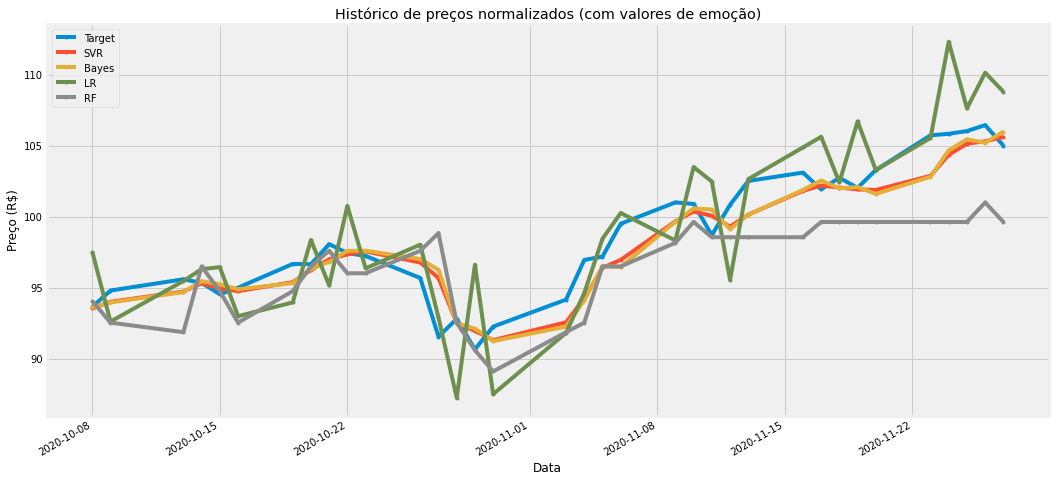

In [623]:
# Yes emo Yes Normalize
np.random.seed(100)
X_train, y_train, X_val, y_val, scaler = getTrainTestDataWithEmotion(perc=0.75, normalize=True)
SVR_m = trainSVR(X_train, y_train, SVR_m.get_params())
RF_m = trainRF(X_train, y_train, RF_m.get_params())
bayes_m = trainBayes(X_train, y_train, bayes_m.get_params())
LR_m = trainLR(X_train, y_train)
results_yes_yes = {}
print(f"SVR Yes Emo Yes Normalize Score: ")
results_yes_yes["SVR"] = get_score_unscaled(SVR_m, X_val, y_val, scaler)
print(f"\nRF Yes Emo Yes Normalize Score: ")
results_yes_yes["RF"] = get_score_unscaled(RF_m, X_val, y_val, scaler)
print(f"\nBayes Yes Emo Yes Normalize Score: ")
results_yes_yes["Bayes"] = get_score_unscaled(bayes_m, X_val, y_val, scaler)
print(f"\nLR Yes Emo Yes Normalize Score: ")
results_yes_yes["LR"] = get_score_unscaled(LR_m, X_val, y_val, scaler)
results["YY"] = results_yes_yes
plot_unscaled(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, scaler, title="Histórico de preços normalizados (com valores de emoção)")

In [612]:
saveResults(results, name="NE_first_result")

# Train - Yes emotion first

SVR Yes Emo No Normalize Score: 
RMSE: 6.439711856106813 | R2: -1.0943709064195546

RF Yes Emo No Normalize Score: 
RMSE: 4.880546634063373 | R2: -0.20297792869362108

Bayes Yes Emo No Normalize Score: 
RMSE: 1.5443969794048955 | R2: 0.8795411777433829

LR Yes Emo No Normalize Score: 
RMSE: 1.7849560418697168 | R2: 0.8390926894337936


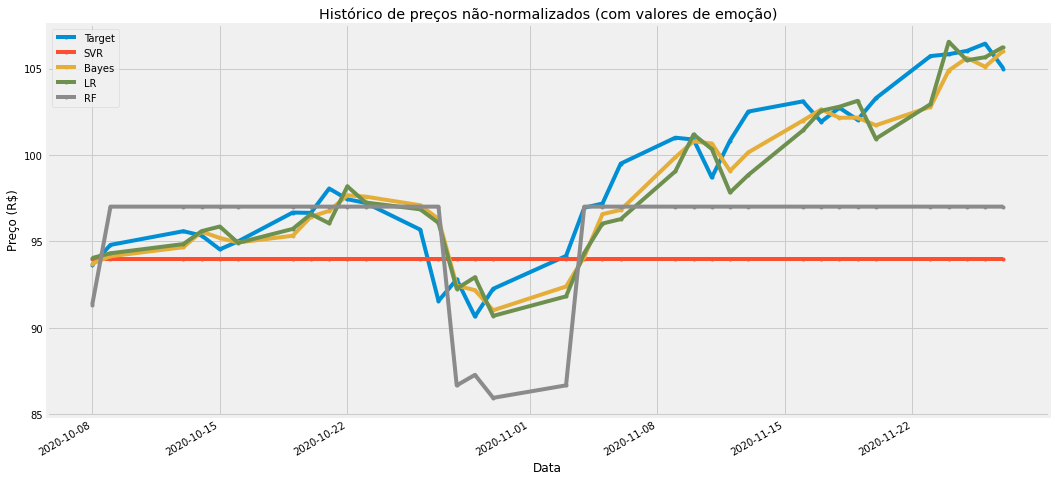

In [569]:
results = {}
# Yes emo No Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestDataWithEmotion(perc=0.75, normalize=False)
SVR_m = trainSVR(X_train, y_train)
RF_m = trainRF(X_train, y_train)
bayes_m = trainBayes(X_train, y_train)
LR_m = trainLR(X_train, y_train)
results_yes_no = {}
print(f"SVR Yes Emo No Normalize Score: ")
results_yes_no["SVR"] = get_score(SVR_m, X_val, y_val)
print(f"\nRF Yes Emo No Normalize Score: ")
results_yes_no["RF"] = get_score(RF_m, X_val, y_val)
print(f"\nBayes Yes Emo No Normalize Score: ")
results_yes_no["Bayes"] = get_score(bayes_m, X_val, y_val)
print(f"\nLR Yes Emo No Normalize Score: ")
results_yes_no["LR"] = get_score(LR_m, X_val, y_val)
results["YN"] = results_yes_no
plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, title="Histórico de preços não-normalizados (com valores de emoção)")

SVR No Emo No Normalize Score: 
RMSE: 6.439711856106813 | R2: -1.0943709064195546

RF No Emo No Normalize Score: 
RMSE: 4.754428276691666 | R2: -0.14160884775435356

Bayes No Emo No Normalize Score: 
RMSE: 1.5443834390637423 | R2: 0.879543289954712

LR No Emo No Normalize Score: 
RMSE: 1.5436100308846383 | R2: 0.8796639062151296


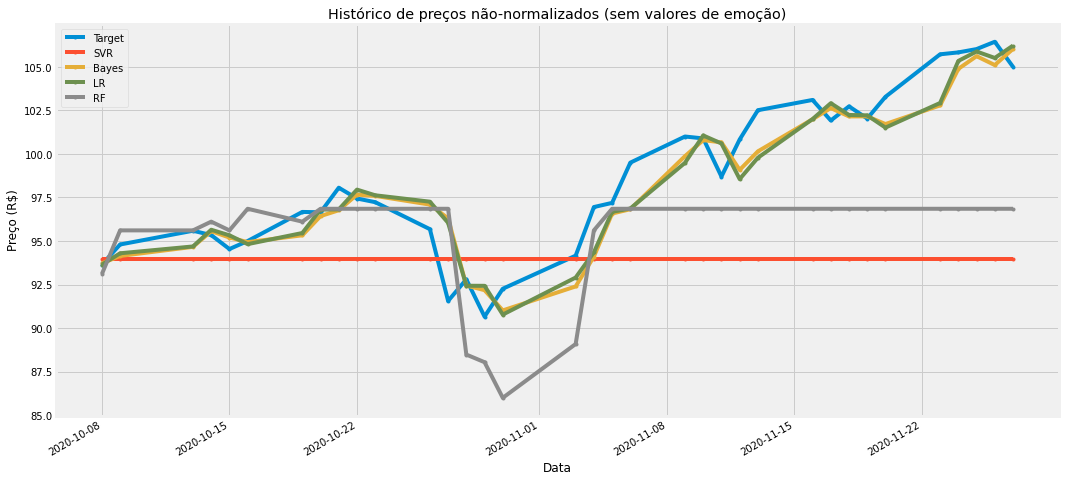

In [570]:
# No emo No Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestData(perc=0.75, normalize=False)
SVR_m = trainSVR(X_train, y_train, SVR_m.get_params())
RF_m = trainRF(X_train, y_train, RF_m.get_params())
bayes_m = trainBayes(X_train, y_train, bayes_m.get_params())
LR_m = trainLR(X_train, y_train)
results_no_no = {}
print(f"SVR No Emo No Normalize Score: ")
results_no_no["SVR"] = get_score(SVR_m, X_val, y_val)
print(f"\nRF No Emo No Normalize Score: ")
results_no_no["RF"] = get_score(RF_m, X_val, y_val)
print(f"\nBayes No Emo No Normalize Score: ")
results_no_no["Bayes"] = get_score(bayes_m, X_val, y_val)
print(f"\nLR No Emo No Normalize Score: ")
results_no_no["LR"] = get_score(LR_m, X_val, y_val) 
results["NN"] = results_no_no
plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, title="Histórico de preços não-normalizados (sem valores de emoção)")

SVR Yes Emo Yes Normalize Score: 
RMSE: 2.1634420477063037 | R2: 0.6481909150782361

RF Yes Emo Yes Normalize Score: 
RMSE: 2.982785342636763 | R2: -0.1066733038601515

Bayes Yes Emo Yes Normalize Score: 
RMSE: 1.3862346117291913 | R2: 0.8871789007355595

LR Yes Emo Yes Normalize Score: 
RMSE: 9.958203244549782 | R2: -0.05700339432899093


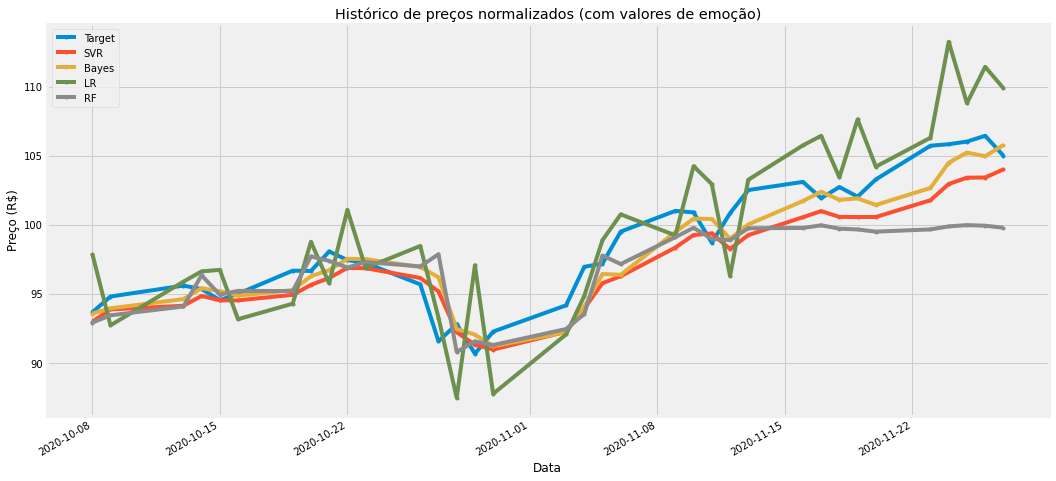

In [30]:
np.random.seed(100)
# Yes emo Yes Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestDataWithEmotion(perc=0.75, normalize=True)
SVR_my = trainSVR(X_train, y_train)
RF_my = trainRF(X_train, y_train)
bayes_my = trainBayes(X_train, y_train)
LR_my = trainLR(X_train, y_train)
results_yes_yes = {}
print(f"SVR Yes Emo Yes Normalize Score: ")
results_yes_yes["SVR"] = get_score_unscaled(SVR_my, X_val, y_val, scaler)
print(f"\nRF Yes Emo Yes Normalize Score: ")
results_yes_yes["RF"] = get_score_unscaled(RF_my, X_val, y_val, scaler)
print(f"\nBayes Yes Emo Yes Normalize Score: ")
results_yes_yes["Bayes"] = get_score_unscaled(bayes_my, X_val, y_val, scaler)
print(f"\nLR Yes Emo Yes Normalize Score: ")
results_yes_yes["LR"] = get_score_unscaled(LR_my, X_val, y_val, scaler)
results["YY"] = results_yes_yes
plot_unscaled(SVR_my, RF_my, bayes_my, LR_my, X_val, y_val, scaler, title="Histórico de preços normalizados (com valores de emoção)")

In [39]:
print('Regressão Linear')
LR_my.get_params()

Regressão Linear


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [45]:
print('Bayes')
bayes_my.get_params()

Bayes


{'alpha_1': 0.001,
 'alpha_2': 1e-07,
 'alpha_init': None,
 'compute_score': True,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-07,
 'lambda_2': 0.001,
 'lambda_init': None,
 'n_iter': 15,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}

In [36]:
print('Random Forest')
RF_my.get_params()

Random Forest


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 16,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [35]:
print('SVR')
SVR_my.get_params()

SVR


{'C': 10,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 0.01,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
results = {}
results["YY"] = results_yes_yes
plot_unscaled(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, scaler, title="Histórico de preços normalizados (com valores de emoção)")

In [28]:
results = {}

SVR No Emo Yes Normalize Score: 
RMSE: 4.1642381396708075 | R2: -1.6017235571547

RF No Emo Yes Normalize Score: 
RMSE: 3.90287766129256 | R2: -1.171414610527496

Bayes No Emo Yes Normalize Score: 
RMSE: 1.3873021490775628 | R2: 0.8873217756833875

LR No Emo Yes Normalize Score: 
RMSE: 9.92244830152364 | R2: -0.0574545094147878


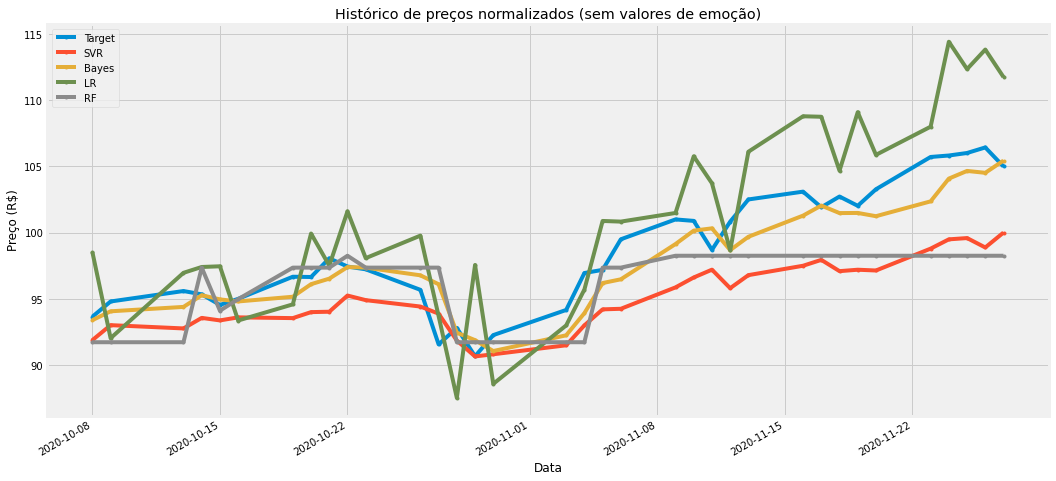

In [29]:
np.random.seed(100)
# No emo Yes Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestData(perc=0.75, normalize=True)

SVR_mn = trainSVR(X_train, y_train)
RF_mn = trainRF(X_train, y_train)
bayes_mn = trainBayes(X_train, y_train)
LR_mn = trainLR(X_train, y_train)


results_no_yes = {}
print(f"SVR No Emo Yes Normalize Score: ")
results_no_yes["SVR"] = get_score_unscaled(SVR_mn, X_val, y_val, scaler)
print(f"\nRF No Emo Yes Normalize Score: ")
results_no_yes["RF"] = get_score_unscaled(RF_mn, X_val, y_val, scaler)
print(f"\nBayes No Emo Yes Normalize Score: ")
results_no_yes["Bayes"] = get_score_unscaled(bayes_mn, X_val, y_val, scaler)
print(f"\nLR No Emo Yes Normalize Score: ")
results_no_yes["LR"] = get_score_unscaled(LR_mn, X_val, y_val, scaler) 
results["NY"] = results_no_yes
plot_unscaled(SVR_mn, RF_mn, bayes_mn, LR_mn, X_val, y_val, scaler, title="Histórico de preços normalizados (sem valores de emoção)")

In [40]:
print('SVR')
SVR_mn.get_params()

SVR


{'C': 10,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 0.1,
 'kernel': 'sigmoid',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [42]:
print('Random Forest')
RF_mn.get_params()

Random Forest


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 16,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [44]:
print('Bayes')
bayes_mn.get_params()

Bayes


{'alpha_1': 0.001,
 'alpha_2': 1e-07,
 'alpha_init': None,
 'compute_score': True,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-07,
 'lambda_2': 0.001,
 'lambda_init': None,
 'n_iter': 15,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}

In [43]:
print('Regressão Linear')
LR_mn.get_params()

Regressão Linear


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [29]:
saveResults(results, name="YE_first_result")

In [23]:
def plot_unscaled(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, scaler, title="Close Price History", X_train = [], y_train = [],full=False):
    if full == True:
        data = X_train.append(X_val)        
        y_val = list(y_val)
        target = list(y_train).extend(y_val)    
    else: 
        target = y_val
        data = X_val
    
    FEATURES = ['PREABE','PREMAX','PREMIN','PREMED','PREOFC','PREOFV', 'PREULT','TOTNEG','QUATOT','VOLTOT']
    
    target_df = data
    target_df['PREULT'] = target
    copy_target = target_df[FEATURES]
    
    unscaled_target = pd.DataFrame(data=scaler.inverse_transform(copy_target), columns=copy_target.columns) 
    pltdata = pd.DataFrame({"Target": list(unscaled_target['PREULT'])}, index=data.index)
        
    pred_df = data
    
    pred = SVR_m.predict(data)        
    pred_df['PREULT'] = pred
    copy_pred = pred_df[FEATURES]
    unscaled_pred = pd.DataFrame(data=scaler.inverse_transform(copy_pred), columns=copy_pred.columns)     
    pltdata["SVR"] = list(unscaled_pred['PREULT'])
    
    pred = bayes_m.predict(data)
    pred_df['PREULT'] = pred
    copy_pred = pred_df[FEATURES]
    unscaled_pred = pd.DataFrame(data=scaler.inverse_transform(copy_pred), columns=copy_pred.columns)            
    pltdata["Bayes"] = list(unscaled_pred['PREULT'])
    
    pred = LR_m.predict(data)
    pred_df['PREULT'] = pred
    copy_pred = pred_df[FEATURES]
    unscaled_pred = pd.DataFrame(data=scaler.inverse_transform(copy_pred), columns=copy_pred.columns)            
    pltdata["LR"] = list(unscaled_pred['PREULT'])
    
    pred = RF_m.predict(data)
    pred_df['PREULT'] = pred
    copy_pred = pred_df[FEATURES]
    unscaled_pred = pd.DataFrame(data=scaler.inverse_transform(copy_pred), columns=copy_pred.columns)     
    pltdata["RF"] = list(unscaled_pred['PREULT'])

    ax = pltdata.plot(style='.-', figsize=(16,8), title=title)
    ax.set_xlabel("Data")
    ax.set_ylabel("Preço (R$)")

In [24]:
def get_score_unscaled(m, X_val, y_val, scaler):
    preds = m.predict(X_val)
    FEATURES = ['PREABE','PREMAX','PREMIN','PREMED','PREOFC','PREOFV', 'PREULT','TOTNEG','QUATOT','VOLTOT']
    pred_df = X_val
    pred_df['PREULT'] = preds
    copy_pred = pred_df[FEATURES]
    unscaled_pred = pd.DataFrame(data=scaler.inverse_transform(copy_pred), columns=copy_pred.columns) 
    
    correct_df = X_val
    correct_df['PREULT'] = y_val
    copy_corr = correct_df[FEATURES]
    unscaled_corr = pd.DataFrame(data=scaler.inverse_transform(copy_corr), columns=copy_corr.columns) 
    
    res = [rmse(unscaled_pred['PREULT'], unscaled_corr['PREULT']), r2_score(unscaled_pred['PREULT'], unscaled_corr['PREULT'])]
    print(f"RMSE: {res[0]} | R2: {res[1]}")
    return res